In [1]:
import re
import pandas as pd
from datetime import datetime

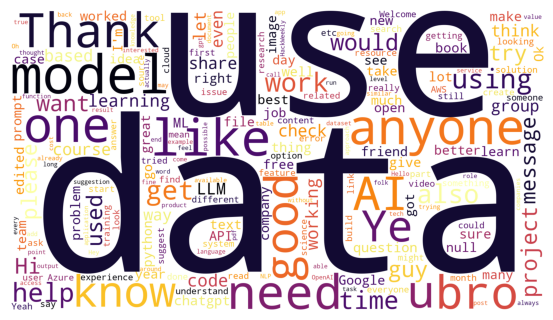

In [10]:
import matplotlib.pyplot as plt
from chatInsights import ChatInsights
from chatInsights import _transformData
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords

# nltk.download('stopwords')

def _preprocess_text(df1) :
     hindi = [chr(c) for c in range(0x0900, 0x097f)]
     df2 = df1[~(df1['message'].str.contains('<Media omitted>')) &
               ~(df1['message'].str.contains('This message was deleted')) &
               ~(df1['message'].str.contains('https://')) &
               ~(df1.message.str.contains('|'.join(hindi)))]

     txt = " ".join(review for review in df2.message)
     return txt

def word_cloud(save_fig = 'N') :
     
     def _preprocess_text(df) :
          hindi = [chr(c) for c in range(0x0900, 0x097f)]
          temp = df[~(df['message'].str.contains('<Media omitted>')) &
                    ~(df['message'].str.contains('This message was deleted')) &
                    ~(df['message'].str.contains('https://')) &
                    ~(df.message.str.contains('|'.join(hindi)))]

          txt = " ".join(review for review in temp.message)
          return txt
     
     data = _transformData(r'E:/MLOps/chatInsights/data/chat1.txt')
     text = _preprocess_text(data)
     # print(text)
     
     stop_words = set(stopwords.words('english'))
     wordcloud = WordCloud(width=1920, height=1080, background_color="white",
                         stopwords=stop_words, random_state=42, colormap='inferno', collocations=False).generate(text)
     plt.figure(figsize=(6, 3))
     plt.imshow(wordcloud)
     
     if save_fig == 'Y' or save_fig == 'y' :
          plt.savefig('wordcloud.png')
     plt.axis("off")
     plt.tight_layout(pad=0)
     plt.show()

word_cloud()

In [3]:
STOPWORDS

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'all',
 'also',
 'am',
 'an',
 'and',
 'any',
 'are',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 "can't",
 'cannot',
 'com',
 'could',
 "couldn't",
 'did',
 "didn't",
 'do',
 'does',
 "doesn't",
 'doing',
 "don't",
 'down',
 'during',
 'each',
 'else',
 'ever',
 'few',
 'for',
 'from',
 'further',
 'get',
 'had',
 "hadn't",
 'has',
 "hasn't",
 'have',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'hence',
 'her',
 'here',
 "here's",
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'however',
 'http',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'k',
 "let's",
 'like',
 'me',
 'more',
 'most',
 "mustn't",
 'my',
 'myself',
 'no',
 'nor',
 'not',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'otherwise',
 'ought',
 'our',
 

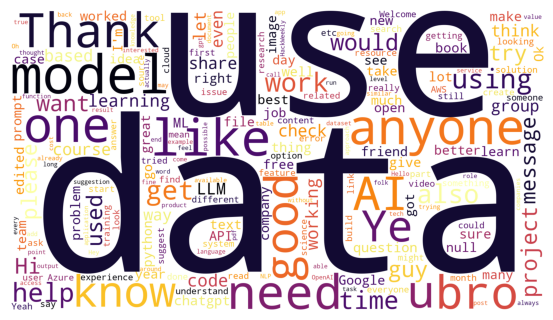

In [1]:
from chatInsights import ChatInsights

data = ChatInsights(r'E:/MLOps/chatInsights/data/chat1.txt')
# data.active_users()
# data.active_year()
# data.active_month()
# data.active_day()
data.word_cloud()

In [3]:
import re
import pandas as pd
from typing import Union, Match


def _fetchDateAndTime(s: str) -> Union[Match[str], bool]:
    pattern = r"^([0-9]+)(\/)([0-9]+)(\/)([0-9][0-9]), ([0-9]+):([0-9][0-9]) (am|pm) - "

    result = re.match(pattern, s)
    if result:
        return result
    return False


def _findAuthor(s: str) -> Union[Match[str], bool]:
    patterns = [
        r"([\w\s]+):",   # any length name
        # r"([\w]+):",  # first name
        # r"([\w]+[\s]+[\w]+):",  # first name + last name
        # r"([\w]+[\s]+[\w]+[\s]+[\w]+):",  # first name + middle mame + last name
        r"([+]\d{1} [(]\d{3}[)] \d{3}-\d{4}):",  # +1 (205) 962-9343
        r"([+]\d{2} \d{5} \d{5}):",  # mobile number (India no.)
        r"([+]\d{2} \d{3} \d{3} \d{4}):",  # mobile number (US no.)
        r"([+]\d{2} \d{2} \d{5}-\d{4}):",  # +55 11 99224-4030
        r"([+]\d{2} \d{4} \d{3} \d{3}):",  # +91 6370 376 940
        r"([+]\d{2} \d{4} \d{4}):",  # +65 8454 7719    
        r"([+]\d{2} \d{3} \d{3} \d{3}):",   # +34 543 678 231
        r"([+]\d{2} \d{4} \d{6}):",    # +21 8549 254168
        r"([+]\d{3} \d{2} \d{3} \d{4}):",    # +597 57 421 6849
        r"([+]\d{3} \d{3} \d{3} \d{4}):",  # +234 810 631 1539
        r"([\w\s]+)[\u263a-\U0001f999]+:",  # any length name and emoji
        r"[\u263a-\U0001f999]+:"   # only emoji
    ]
    pattern = "^" + "|".join(patterns)
    result = re.match(pattern, s)
    if result:
        return result
    return False


def _fetchMessages(line: str) -> tuple:
    splitLine = line.split(" - ")
    dateTime = splitLine[0]
    date, time = dateTime.split(", ")
    message = " ".join(splitLine[1:])
    if _findAuthor(message):
        splitMessage = message.split(": ")
        author = splitMessage[0]
        message = " ".join(splitMessage[1:])
    else:
        author = None

    return date, time, author, message


def _transformData(file_path: str) -> pd.DataFrame:
    from datetime import datetime

    URLPATTERN = r"(https?://\S+)"
    MEDIAPATTERN = r"<Media omitted>"

    parsedData = []

    with open(file_path, "r", encoding="utf-8") as fp:
        fp.readline()
        # fp.readline()
        messageBuffer: list[str] = []

        date, time, author = None, None, None
        while True:
            line = fp.readline().replace("\u202f", " ")
            if not line:
                break
            line = line.strip()
            if _fetchDateAndTime(line):
                if len(messageBuffer) > 0:
                    parsedData.append(
                        [
                            date,
                            time,
                            author,
                            re.sub(r"\s+", " ", " ".join(messageBuffer)),
                        ]
                    )
                messageBuffer.clear()
                date, time, author, message = _fetchMessages(line)
                messageBuffer.append(message)
            else:
                messageBuffer.append(line)

    parsedData.append(
          [
               date,
               time,
               author,
               re.sub(r"\s+", " ", " ".join(messageBuffer)),
          ]
    )

    df = pd.DataFrame(parsedData, columns=["date", "time", "user", "message"])

    df = df.dropna()
    df = df.reset_index(drop=True)
    df["words"] = df["message"].apply(
        lambda s: len(s.split(" "))
    )  # Count number of word's in each message
    df["date"] = pd.to_datetime(df["date"], format="%d/%m/%y")
    df["media_count"] = (
        df["message"].apply(lambda x: re.findall(MEDIAPATTERN, x)).str.len()
    )
    df["url_count"] = df["message"].apply(lambda x: re.findall(URLPATTERN, x)).str.len()

    weeks = {
        0: "Monday",
        1: "Tuesday",
        2: "Wednesday",
        3: "Thrusday",
        4: "Friday",
        5: "Saturday",
        6: "Sunday",
    }
    df["day"] = df["date"].dt.weekday.map(weeks)

    # Converting 12 hour formate to 24 hour.
    lst = []
    for i in df["time"]:
        out_time = datetime.strftime(datetime.strptime(i, "%I:%M %p"), "%H:%M")
        lst.append(out_time)
    df["24H_time"] = lst

    df["hours"] = df["24H_time"].apply(lambda x: x.split(":")[0])

    df["msg_count"] = df["date"].map(df["date"].value_counts().to_dict())

    df["year"] = df["date"].dt.year

    df["mon"] = df["date"].dt.month
    months = {
        1: "Jan",
        2: "Feb",
        3: "Mar",
        4: "Apr",
        5: "May",
        6: "Jun",
        7: "Jul",
        8: "Aug",
        9: "Sep",
        10: "Oct",
        11: "Nov",
        12: "Dec",
    }
    df["month"] = df["mon"].map(months)
    df.drop("mon", axis=1, inplace=True)
    df["month_year"] = df.apply(lambda x: x["month"] + " " + str(x["year"]), axis=1)
    df["msg_count_monthly"] = df["month_year"].map(
        df["month_year"].value_counts().to_dict()
    )

    return df


In [4]:
df = _transformData(r'E:/MLOps/ChatInsights/data/chat1.txt')
df.shape

(19745, 15)

In [11]:
df1 = df['year'].value_counts().to_frame().reset_index()

In [12]:
df1

,year,count
0,2023,14678
1,2024,2605
2,2022,2462


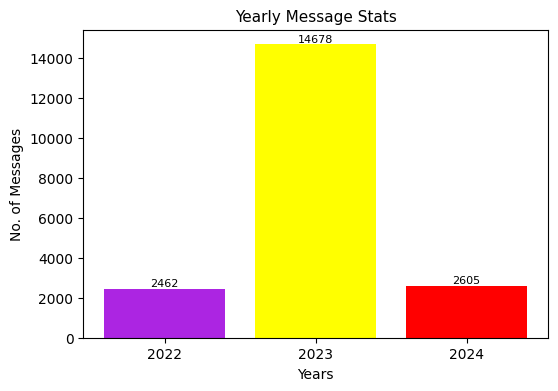

In [18]:
import matplotlib.pyplot as plt

df1 = df['year'].value_counts().to_frame().reset_index()

# Create the figure and axis
plt.figure(figsize=(6, 4))

# Plotting the data
bars = plt.bar(df1['year'], df1['count'], color=['#ffff00', '#ff0000', '#ac25e2'])

# Adding count labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, int(yval), ha='center', va='bottom', fontsize=8)

# Set labels and title
plt.xlabel('Years')
plt.ylabel('No. of Messages')
plt.title('Yearly Message Stats', fontdict={'fontsize': 11})

# Ensure x-axis shows integer values
plt.xticks(df1['year'])

# Save the plot
plt.savefig('active_year.png', bbox_inches='tight')

# Show the plot
plt.show()

In [95]:
df.tail()

,date,time,user,message,words,media_count,url_count,day,24H_time,hours,msg_count,year,month,month_year,msg_count_monthly
35,2023-11-08,10:47 pm,+91 98316 13620,What is this RAG thing thats going around,8,0,0,Wednesday,22:47,22,40,2023,Nov,Nov 2023,40
36,2023-11-08,10:48 pm,+91 98316 13620,"can someone explain, I have been too deep into...",17,0,0,Wednesday,22:48,22,40,2023,Nov,Nov 2023,40
37,2023-11-08,10:48 pm,+91 98316 13620,any short description or a link to some resour...,12,0,0,Wednesday,22:48,22,40,2023,Nov,Nov 2023,40
38,2023-11-08,10:50 pm,+91 93548 41168,https://youtu.be/T-D1OfcDW1M?feature=shared,1,0,1,Wednesday,22:50,22,40,2023,Nov,Nov 2023,40
39,2023-11-08,11:26 pm,+91 96009 63961,Guys I need some inputs on one use case.,9,0,0,Wednesday,23:26,23,40,2023,Nov,Nov 2023,40


In [70]:
df.isnull().sum().sum()

0

In [54]:
URLPATTERN = r'(https?://\S+)'
MEDIAPATTERN = r'<Media omitted>'

In [61]:
def _fetchMessages(line: str) -> tuple:
    splitLine = line.split(" - ")
    dateTime = splitLine[0]
    date, time = dateTime.split(", ")
    message = " ".join(splitLine[1:])
    if _findAuthor(message):
        splitMessage = message.split(": ")
        author = splitMessage[0]
        message = " ".join(splitMessage[1:])
    else:
        author = None

    return date, time, author, message

_fetchMessages("03/11/22, 2:03 pm - +91 73688 94258: Any Android ios dev here?")

('03/11/22', '2:03 pm', '+91 73688 94258', 'Any Android ios dev here?')

In [3]:
def _startsWithDateAndTime(s: str) :
    pattern = r"^([0-9]+)(\/)([0-9]+)(\/)([0-9][0-9]), ([0-9]+):([0-9][0-9]) (am|pm) - "

    result = re.match(pattern, s)
    if result:
        return result
    return False

_startsWithDateAndTime("03/11/22, 2:03 pm - +91 73688 94258: Any Android ios dev here?")

<re.Match object; span=(0, 20), match='03/11/22, 2:03 pm - '>

In [59]:
def _findAuthor(s: str):
    patterns = [
        r"([\w\s]+):",   # any length name
        # r"([\w]+):",  # First Name
        # r"([\w]+[\s]+[\w]+):",  # First Name + Last Name
        # r"([\w]+[\s]+[\w]+[\s]+[\w]+):",  # First Name + Middle Name + Last Name
        r"([+]\d{1} [(]\d{3}[)] \d{3}-\d{4}):",  # +1 (205) 962-9343
        r"([+]\d{2} \d{5} \d{5}):",  # Mobile Number (India no.)
        r"([+]\d{2} \d{3} \d{3} \d{4}):",  # Mobile Number (US no.)
        r"([+]\d{2} \d{2} \d{5}-\d{4}):",  # +55 11 99224-4030
        r"([+]\d{2} \d{4} \d{3} \d{3}):",  # +91 6370 376 940
        r"([+]\d{2} \d{4} \d{4}):",  # +65 8454 7719    
        r"([+]\d{2} \d{3} \d{3} \d{3}):",   # +34 543 678 231
        r"([+]\d{2} \d{4} \d{6}):",    # +21 8549 254168
        r"([+]\d{3} \d{2} \d{3} \d{4}):",    # +597 57 421 6849
        r"([+]\d{3} \d{3} \d{3} \d{4}):",  # +234 810 631 1539
        r"([\w\s]+)[\u263a-\U0001f999]+:",  # Name and Emoji
        r"[\u263a-\U0001f999]+:"   # only emoji
    ]
    pattern = "^" + "|".join(patterns)
    result = re.match(pattern, s)
    if result:
        return result
    return False

_FindAuthor("🤩🤩🤩: Any Android ios dev here?")

<re.Match object; span=(0, 4), match='🤩🤩🤩:'>

In [63]:
import re
import pandas as pd
from typing import Union, Match


def _startsWithDateAndTime(s: str) -> Union[Match[str], bool]:
    pattern = r"^([0-9]+)(\/)([0-9]+)(\/)([0-9][0-9]), ([0-9]+):([0-9][0-9]) (am|pm) - "

    result = re.match(pattern, s)
    if result:
        return result
    return False


def _FindAuthor(s: str) -> Union[Match[str], bool]:
    patterns = [
        r"([\w]+):",  # First Name
        r"([\w]+[\s]+[\w]+):",  # First Name + Last Name
        r"([\w]+[\s]+[\w]+[\s]+[\w]+):",  # First Name + Middle Name + Last Name
        r"([+]\d{1} [(]\d{3}[)] \d{3}-\d{4}):",  # +1 (205) 962-9343
        r"([+]\d{2} \d{5} \d{5}):",  # Mobile Number (India no.)
        r"([+]\d{2} \d{3} \d{3} \d{4}):",  # Mobile Number (US no.)
        r"([+]\d{2} \d{2} \d{5}-\d{4}):",  # +55 11 99224-4030
        r"([+]\d{2} \d{4} \d{3} \d{3}):",  # +91 6370 376 940
        r"([+]\d{2} \d{4} \d{4}):",  # +65 8454 7719     +353 83 015 8907
        r"([+]\d{2} \d{3} \d{3} \d{3}):",
        r"([+]\d{2} \d{4} \d{6}):",
        r"([+]\d{3} \d{2} \d{3} \d{4}):",
        r"([+]\d{3} \d{3} \d{3} \d{4}):",  # +234 810 631 1539
        r"([\w]+)[\u263a-\U0001f999]+:",  # Name and Emoji
    ]
    pattern = "^" + "|".join(patterns)
    result = re.match(pattern, s)
    if result:
        return result
    return False


def _getDataPoint(line: str) -> tuple:
    splitLine = line.split(" - ")
    dateTime = splitLine[0]
    date, time = dateTime.split(", ")
    message = " ".join(splitLine[1:])
    if _FindAuthor(message):
        splitMessage = message.split(": ")
        author = splitMessage[0]
        message = " ".join(splitMessage[1:])
    else:
        author = None

    return date, time, author, message


def _fetch(file_path: str) -> pd.DataFrame:
    from datetime import datetime

    URLPATTERN = r"(https?://\S+)"
    MEDIAPATTERN = r"<Media omitted>"

    parsedData = []

    with open(file_path, "r", encoding="utf-8") as fp:
        fp.readline()
        fp.readline()
        messageBuffer: list[str] = []

        date, time, author = None, None, None
        while True:
            line = fp.readline().replace("\u202f", " ")
            if not line:
                break
            line = line.strip()
            if _startsWithDateAndTime(line):
                if len(messageBuffer) > 0:
                    parsedData.append(
                        [
                            date,
                            time,
                            author,
                            re.sub(r"\s+", " ", " ".join(messageBuffer)),
                        ]
                    )
                messageBuffer.clear()
                date, time, author, message = _getDataPoint(line)
                messageBuffer.append(message)
            else:
                messageBuffer.append(line)

    df = pd.DataFrame(parsedData, columns=["date", "time", "user", "message"])

    df = df.dropna()
    df = df.reset_index(drop=True)
    df["words"] = df["message"].apply(
        lambda s: len(s.split(" "))
    )  # Count number of word's in each message
    df["date"] = pd.to_datetime(df["date"], format="%d/%m/%y")
    df["media_count"] = (
        df["message"].apply(lambda x: re.findall(MEDIAPATTERN, x)).str.len()
    )
    df["url_count"] = df["message"].apply(lambda x: re.findall(URLPATTERN, x)).str.len()

    weeks = {
        0: "Monday",
        1: "Tuesday",
        2: "Wednesday",
        3: "Thrusday",
        4: "Friday",
        5: "Saturday",
        6: "Sunday",
    }
    df["day"] = df["date"].dt.weekday.map(weeks)

    # Converting 12 hour formate to 24 hour.
    lst = []
    for i in df["time"]:
        out_time = datetime.strftime(datetime.strptime(i, "%I:%M %p"), "%H:%M")
        lst.append(out_time)
    df["24H_time"] = lst

    df["hours"] = df["24H_time"].apply(lambda x: x.split(":")[0])

    df["msg_count"] = df["date"].map(df["date"].value_counts().to_dict())

    df["year"] = df["date"].dt.year

    df["mon"] = df["date"].dt.month
    months = {
        1: "Jan",
        2: "Feb",
        3: "Mar",
        4: "Apr",
        5: "May",
        6: "Jun",
        7: "Jul",
        8: "Aug",
        9: "Sep",
        10: "Oct",
        11: "Nov",
        12: "Dec",
    }
    df["month"] = df["mon"].map(months)
    df.drop("mon", axis=1, inplace=True)
    df["month_year"] = df.apply(lambda x: x["month"] + " " + str(x["year"]), axis=1)
    df["msg_count_monthly"] = df["month_year"].map(
        df["month_year"].value_counts().to_dict()
    )

    return df

file_path = r'E:\MLOps\chatinsights\tests\test_data\chat4.txt'
df = _fetch(file_path)
df.shape

(37, 15)

In [51]:
df

,date,time,user,message,words,media_count,url_count,day,24H_time,hours,msg_count,year,month,month_year,msg_count_monthly
0,2022-11-03,2:03 pm,+91 73688 94258,Any Android ios dev here? Have a freelance pro...,17,0,0,Thrusday,14:03,14,8,2022,Nov,Nov 2022,8
1,2022-11-03,2:03 pm,+91 73688 94258,@919003135354,1,0,0,Thrusday,14:03,14,8,2022,Nov,Nov 2022,8
2,2022-11-03,5:20 pm,+91 85900 82524,BigCode releases The Stack the largest code da...,85,0,1,Thrusday,17:20,17,8,2022,Nov,Nov 2022,8
3,2022-11-03,5:21 pm,+234 810 631 1539,<Media omitted>,2,1,0,Thrusday,17:21,17,8,2022,Nov,Nov 2022,8
4,2022-11-03,5:26 pm,+91 90738 34650,Are you running docker using sudo?,6,0,0,Thrusday,17:26,17,8,2022,Nov,Nov 2022,8
5,2022-11-03,5:27 pm,+234 810 631 1539,"yeah, running it with sudo produces that",7,0,0,Thrusday,17:27,17,8,2022,Nov,Nov 2022,8
6,2022-11-03,5:27 pm,+234 810 631 1539,"without sudo, it produces permission error",6,0,0,Thrusday,17:27,17,8,2022,Nov,Nov 2022,8
7,2022-11-03,5:27 pm,+91 90738 34650,Can you without it?,4,0,0,Thrusday,17:27,17,8,2022,Nov,Nov 2022,8


In [7]:
# pd.set_option('display.max_rows', None)

df[df['user'].isna()].shape

(286, 4)

In [14]:
df = df.dropna()

In [15]:
df.shape

(19744, 4)

In [62]:
df = df.reset_index(drop=True)

In [66]:
df['words'] = df['message'].apply(lambda s: len(s.split(' '))) 
df['date'] = pd.to_datetime(df['date'], format = '%d/%m/%y')
df['media'] = df.message.apply(lambda x: re.findall(MEDIAPATTERN, x)).str.len()
df['url'] = df.message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()

In [67]:
df.head()

,date,time,user,message,words,media,url
0,2022-11-03,2:03 pm,+91 73688 94258,Any Android ios dev here? Have a freelance pro...,17,0,0
1,2022-11-03,2:03 pm,+91 73688 94258,@919003135354,1,0,0
2,2022-11-03,5:20 pm,+91 85900 82524,BigCode releases The Stack the largest code da...,85,0,1
3,2022-11-03,5:21 pm,+234 810 631 1539,<Media omitted>,2,1,0
4,2022-11-03,5:26 pm,+91 90738 34650,Are you running docker using sudo?,6,0,0


In [69]:
weeks = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thrusday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}
df['day'] = df['date'].dt.weekday.map(weeks)

In [71]:
# Converting 12 hour formate to 24 hour.
lst = []
for i in df['time']:
    out_time = datetime.strftime(datetime.strptime(i, '%I:%M %p'), '%H:%M')
    lst.append(out_time)
df['24H_time'] = lst

df['hours'] = df['24H_time'].apply(lambda x: x.split(':')[0])

df['msg_count'] = df['date'].map(df['date'].value_counts().to_dict())

df['year'] = df['date'].dt.year

df['mon'] = df['date'].dt.month

In [73]:
months = {
    1: 'Jan',
    2: 'Feb',
    3: 'Mar',
    4: 'Apr',
    5: 'May',
    6: 'Jun',
    7: 'Jul',
    8: 'Aug',
    9: 'Sep',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec'
}

df['month'] = df['mon'].map(months)
df.drop('mon', axis = 1, inplace = True)
df['month_year'] = df.apply(lambda x: x['month'] + ' ' + str(x['year']), axis = 1)
df['msg_count_monthly'] = df['month_year'].map(df['month_year'].value_counts().to_dict())

In [74]:
df.head()

,date,time,user,message,words,media,url,day,24H_time,hours,msg_count,year,month,month_year,msg_count_monthly
0,2022-11-03,2:03 pm,+91 73688 94258,Any Android ios dev here? Have a freelance pro...,17,0,0,Thrusday,14:03,14,56,2022,Nov,Nov 2022,1268
1,2022-11-03,2:03 pm,+91 73688 94258,@919003135354,1,0,0,Thrusday,14:03,14,56,2022,Nov,Nov 2022,1268
2,2022-11-03,5:20 pm,+91 85900 82524,BigCode releases The Stack the largest code da...,85,0,1,Thrusday,17:20,17,56,2022,Nov,Nov 2022,1268
3,2022-11-03,5:21 pm,+234 810 631 1539,<Media omitted>,2,1,0,Thrusday,17:21,17,56,2022,Nov,Nov 2022,1268
4,2022-11-03,5:26 pm,+91 90738 34650,Are you running docker using sudo?,6,0,0,Thrusday,17:26,17,56,2022,Nov,Nov 2022,1268


In [9]:
df = df.dropna()
df = df.reset_index(drop = True)
df['words'] = df['message'].apply(lambda s: len(s.split(' ')))  # Count number of word's in each message
df['date'] = pd.to_datetime(df['date'], format = '%d/%m/%y')
df['media_count'] = df['message'].apply(lambda x: re.findall(MEDIAPATTERN, x)).str.len()
df['url_count'] = df['message'].apply(lambda x: re.findall(URLPATTERN, x)).str.len()

weeks = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thrusday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}
df['day'] = df['date'].dt.weekday.map(weeks)

# Converting 12 hour formate to 24 hour.
lst = []
for i in df['time']:
    out_time = datetime.strftime(datetime.strptime(i, '%I:%M %p'), '%H:%M')
    lst.append(out_time)
df['24H_time'] = lst

df['hours'] = df['24H_time'].apply(lambda x: x.split(':')[0])

df['msg_count'] = df['date'].map(df['date'].value_counts().to_dict())

df['year'] = df['date'].dt.year

df['mon'] = df['date'].dt.month
months = {
    1: 'Jan',
    2: 'Feb',
    3: 'Mar',
    4: 'Apr',
    5: 'May',
    6: 'Jun',
    7: 'Jul',
    8: 'Aug',
    9: 'Sep',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec'
}
df['month'] = df['mon'].map(months)
df.drop('mon', axis = 1, inplace = True)
df['month_year'] = df.apply(lambda x: x['month'] + ' ' + str(x['year']), axis = 1)
df['msg_count_monthly'] = df['month_year'].map(df['month_year'].value_counts().to_dict())

In [10]:
df.head()

,date,time,user,message,words,media_count,url_count,day,24H_time,hours,msg_count,year,month,month_year,msg_count_monthly
0,2022-11-03,2:03 pm,+91 73688 94258,Any Android ios dev here? Have a freelance pro...,17,0,0,Thrusday,14:03,14,56,2022,Nov,Nov 2022,1268
1,2022-11-03,2:03 pm,+91 73688 94258,@919003135354,1,0,0,Thrusday,14:03,14,56,2022,Nov,Nov 2022,1268
2,2022-11-03,5:20 pm,+91 85900 82524,BigCode releases The Stack the largest code da...,85,0,1,Thrusday,17:20,17,56,2022,Nov,Nov 2022,1268
3,2022-11-03,5:21 pm,+234 810 631 1539,<Media omitted>,2,1,0,Thrusday,17:21,17,56,2022,Nov,Nov 2022,1268
4,2022-11-03,5:26 pm,+91 90738 34650,Are you running docker using sudo?,6,0,0,Thrusday,17:26,17,56,2022,Nov,Nov 2022,1268


In [90]:
import re
x = 'BigCode releases The Stack the largest code dataset (like GitHub Copilot)       BigCode is a 3TB dataset of permissively licensed code scraped from GitHub, including 30 languages.    The dataset was created as part of the BigCode Project, an open scientific collaboration working on the responsible development of Large Language Models for    Code (Code LLMs). The Stack serves as a pre-training dataset for Code LLMs, i.e., code-generating AI systems which enable the synthesis of programs from natural language descriptions as well as other from code snippets.     https://huggingface.co/datasets/bigcode/the-stack'

re.sub(r'\s+', ' ', x)

'BigCode releases The Stack the largest code dataset (like GitHub Copilot) BigCode is a 3TB dataset of permissively licensed code scraped from GitHub, including 30 languages. The dataset was created as part of the BigCode Project, an open scientific collaboration working on the responsible development of Large Language Models for Code (Code LLMs). The Stack serves as a pre-training dataset for Code LLMs, i.e., code-generating AI systems which enable the synthesis of programs from natural language descriptions as well as other from code snippets. https://huggingface.co/datasets/bigcode/the-stack'

In [86]:
df.head()

,date,time,mobile_no,message
0,03/11/22,2:03 pm,+91 73688 94258,Any Android ios dev here? Have a freelance pro...
1,03/11/22,2:03 pm,+91 73688 94258,@919003135354
2,03/11/22,5:20 pm,+91 85900 82524,BigCode releases The Stack the largest code da...
3,03/11/22,5:21 pm,None,+234 810 631 1539: <Media omitted>
4,03/11/22,5:26 pm,+91 90738 34650,Are you running docker using sudo?


In [30]:
import re
import pandas as pd

# Sample data as a multiline string
data = '''03/11/22, 2:03 pm - +91 73688 94258: Any Android ios dev here?
Have a freelance project for app development.

Interested can let me know:)
03/11/22, 2:03 pm - +91 73688 94258: @919003135354
03/11/22, 5:20 pm - +91 85900 82524: BigCode releases The Stack: the largest code dataset (like GitHub Copilot)

BigCode is a 3TB dataset of permissively licensed code scraped from GitHub, including 30 languages.

The dataset was created as part of the BigCode Project, an open scientific collaboration working on the responsible development of Large Language Models for Code (Code LLMs). The Stack serves as a pre-training dataset for Code LLMs, i.e., code-generating AI systems which enable the synthesis of programs from natural language descriptions as well as other from code snippets.

https://huggingface.co/datasets/bigcode/the-stack'''

# Split the data into lines
lines = data.split('\n')

# Initialize a list to store the extracted data
extracted_data = []

# Regular expression pattern to match the date, time, mobile number, and message
pattern = re.compile(r'(\d{2}/\d{2}/\d{2}), (\d{1,2}:\d{2}\s[ap]m) - (\+\d{2}\s\d+): (.*)')

# Temporary storage for multi-line messages
current_message = None

for line in lines:
    match = pattern.match(line)
    if match:
        # If there is an ongoing multi-line message, save it first
        if current_message:
            extracted_data.append(current_message)
            current_message = None
        
        # Extract details from the matched line
        date, time, mobile_no, message = match.groups()
        current_message = [date, time, mobile_no, message]
    else:
        # Append the line to the ongoing multi-line message
        if current_message:
            current_message[3] += ' ' + line.strip()

# Append the last message if there was one
if current_message:
    extracted_data.append(current_message)

# Convert the extracted data into a DataFrame
df = pd.DataFrame(extracted_data, columns=['date', 'time', 'mobile_no', 'message'])

# Display the DataFrame
print(df)


,Date,Time,Author,Message,Letter's,Word's,Media_Count,Url_Count,Day,24H_Time,Hours,Msg_count,Year,Month,id


In [ ]:

    # df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message'])
    # df = df.dropna()
    # df = df.reset_index(drop=True)
    # df['Letter\'s'] = df['Message'].apply(lambda s: len(s))  # Count number of letters in each message
    # df['Word\'s'] = df['Message'].apply(lambda s: len(s.split(' ')))  # Count number of word's in each message
    # df['Date'] = pd.to_datetime(df['Date'])
    # df['Media_Count'] = df.Message.apply(lambda x: re.findall(MEDIAPATTERN, x)).str.len()
    # df['Url_Count'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()

    # weeks = {
    #     0: 'Monday',
    #     1: 'Tuesday',
    #     2: 'Wednesday',
    #     3: 'Thrusday',
    #     4: 'Friday',
    #     5: 'Saturday',
    #     6: 'Sunday'
    # }
    # df['Day'] = df['Date'].dt.weekday.map(weeks)

    # # Converting 12 hour formate to 24 hour.
    # lst = []
    # for i in df['Time']:
    #     out_time = datetime.strftime(datetime.strptime(i, '%I:%M %p'), '%H:%M')
    #     lst.append(out_time)
    # df['24H_Time'] = lst

    # df['Hours'] = df['24H_Time'].apply(lambda x: x.split(':')[0])

    # df['Msg_count'] = df['Date'].map(df['Date'].value_counts().to_dict())

    # df['Year'] = df['Date'].dt.year

    # df['Mon'] = df['Date'].dt.month
    # months = {
    #     1: 'Jan',
    #     2: 'Feb',
    #     3: 'Mar',
    #     4: 'Apr',
    #     5: 'May',
    #     6: 'Jun',
    #     7: 'Jul',
    #     8: 'Aug',
    #     9: 'Sep',
    #     10: 'Oct',
    #     11: 'Nov',
    #     12: 'Dec'
    # }
    # df['Month'] = df['Mon'].map(months)
    # df.drop('Mon', axis=1, inplace=True)
    # # df['Month_Year'] = df.apply(lambda x: x['Month'] + ' ' + str(x['Year']), axis=1)
    # # df['Msg_count_monthly'] = df['Month_Year'].map(df['Month_Year'].value_counts().to_dict())

    # df['id'] = df.index
    # return df